In [ ]:
!pip install transformers datasets accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (4

In [ ]:
from datasets import load_dataset
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from transformers import BertTokenizer, BertModel, AdamW, get_scheduler
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
from tqdm.auto import tqdm

In [ ]:
from sklearn.preprocessing import LabelEncoder
import json

df_train = pd.read_csv('LDA_train_df.csv')
df_val = pd.read_csv('LDA_val_df.csv')
df_test = pd.read_csv('LDA_test_df.csv')

with open('label_mapping.json', 'r') as f:
    label_mapping = json.load(f)

label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(list(label_mapping.keys()))

In [ ]:
df_train['topic_distribution'] = df_train['topic_distribution'].apply(lambda x: list(map(float, x.split(','))))
df_val['topic_distribution'] = df_val['topic_distribution'].apply(lambda x: list(map(float, x.split(','))))
df_test['topic_distribution'] = df_test['topic_distribution'].apply(lambda x: list(map(float, x.split(','))))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertModel

class LDA_attended_BERTModel(nn.Module):
    def __init__(self, bert_model, num_labels):
        super(LDA_attended_BERTModel, self).__init__()
        self.bert = bert_model
        self.bert_hidden_size = self.bert.config.hidden_size
        self.topic_size = 10
        self.fc_layers = nn.Sequential(
            nn.Linear(self.bert_hidden_size, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
        )
        self.final_layer = nn.Sequential(
            nn.Linear(32 + self.topic_size, 16),
            nn.ReLU(),
            nn.Linear(16, num_labels)
        )

    def forward(self, input_ids, attention_mask, topic_distribution):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        intermediate_output = self.fc_layers(pooled_output)
        combined_output = torch.cat((intermediate_output, topic_distribution), dim=1)
        logits = self.final_layer(combined_output)
        return logits

In [ ]:
class NewsDataset(Dataset):
    def __init__(self, documents, labels, topic_distributions, tokenizer, max_length):
        self.documents = documents
        self.labels = labels
        self.topic_distributions = topic_distributions
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.documents)

    def __getitem__(self, idx):
        document = self.documents[idx]
        label = self.labels[idx]
        topic_distribution = self.topic_distributions[idx]

        encoding = self.tokenizer(
            document,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(label)
        item['topic_distribution'] = torch.tensor(topic_distribution, dtype=torch.float)

        return item

In [ ]:
tokenizer = BertTokenizer.from_pretrained('klue/roberta-base')
model = LDA_attended_BERTModel(num_labels=len(label_encoder.classes_), bert_model = BertModel.from_pretrained('klue/roberta-base'))

train_dataset = NewsDataset(df_train['document'].tolist(), df_train['press_encoded'].tolist(), df_train['topic_distribution'].tolist(), tokenizer, max_length=512)
val_dataset = NewsDataset(df_val['document'].tolist(), df_val['press_encoded'].tolist(), df_val['topic_distribution'].tolist(), tokenizer, max_length=512)
test_dataset = NewsDataset(df_test['document'].tolist(), df_test['press_encoded'].tolist(), df_test['topic_distribution'].tolist(), tokenizer, max_length=512)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8)
test_dataloader = DataLoader(test_dataset, batch_size=8)

optimizer = AdamW(model.parameters(), lr=1e-5)
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.

In [ ]:
progress_bar = tqdm(range(num_training_steps))

total_steps = 0
ts = []
tl = []
ta = []

for epoch in range(num_epochs):
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for step, batch in enumerate(train_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        topic_distribution = batch['topic_distribution'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, topic_distribution=topic_distribution)

        loss_fn = nn.CrossEntropyLoss()
        loss = loss_fn(outputs, labels)

        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        total_loss += loss.item()
        predictions = torch.argmax(outputs, dim=-1)
        correct_predictions += (predictions == labels).sum().item()
        total_predictions += labels.size(0)

        progress_bar.update(1)

        if (total_steps + 1) % 100 == 0:
            avg_loss = total_loss / (step + 1)
            accuracy = correct_predictions / total_predictions
            print(f"Step {total_steps + 1}/{len(train_dataloader)}")
            ts.append(total_steps)
            print(f"Train Loss: {avg_loss:.4f}, Train Accuracy: {accuracy:.4f}")
            tl.append(avg_loss)
            ta.append(accuracy)

        total_steps += 1

    avg_loss = total_loss / len(train_dataloader)
    accuracy = correct_predictions / total_predictions

  0%|          | 0/2520 [00:00<?, ?it/s]

Step 100/840
Train Loss: 1.5905, Train Accuracy: 0.2612
Step 200/840
Train Loss: 1.5856, Train Accuracy: 0.2581
Step 300/840
Train Loss: 1.5835, Train Accuracy: 0.2596
Step 400/840
Train Loss: 1.5725, Train Accuracy: 0.2716
Step 500/840
Train Loss: 1.5678, Train Accuracy: 0.2745
Step 600/840
Train Loss: 1.5554, Train Accuracy: 0.2821
Step 700/840
Train Loss: 1.5439, Train Accuracy: 0.2873
Step 800/840
Train Loss: 1.5345, Train Accuracy: 0.2961
Step 900/840
Train Loss: 1.4683, Train Accuracy: 0.3354
Step 1000/840
Train Loss: 1.4534, Train Accuracy: 0.3445
Step 1100/840
Train Loss: 1.4183, Train Accuracy: 0.3808
Step 1200/840
Train Loss: 1.3773, Train Accuracy: 0.4000
Step 1300/840
Train Loss: 1.3391, Train Accuracy: 0.4144
Step 1400/840
Train Loss: 1.2995, Train Accuracy: 0.4379
Step 1500/840
Train Loss: 1.2512, Train Accuracy: 0.4591
Step 1600/840
Train Loss: 1.2096, Train Accuracy: 0.4770
Step 1700/840
Train Loss: 0.9248, Train Accuracy: 0.6000
Step 1800/840
Train Loss: 0.8807, Train 

In [ ]:
def evaluate(model, dataloader):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    all_labels = []
    all_predictions = []
    all_probabilities = []

    progress_bar = tqdm(total=len(dataloader), desc="Evaluating")

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            topic_distribution = batch['topic_distribution'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, topic_distribution=topic_distribution)

            if isinstance(outputs, tuple):
                logits = outputs[0]
            else:
                logits = outputs

            probabilities = torch.softmax(logits, dim=-1)
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)

            total_loss += loss.item()
            predictions = torch.argmax(logits, dim=-1)
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

            progress_bar.update(1)

    progress_bar.close()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / total_predictions
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    roc_auc = roc_auc_score(all_labels, np.array(all_probabilities), multi_class='ovr')

    print(f"Loss: {avg_loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")

    return avg_loss, accuracy, f1, precision, recall, roc_auc

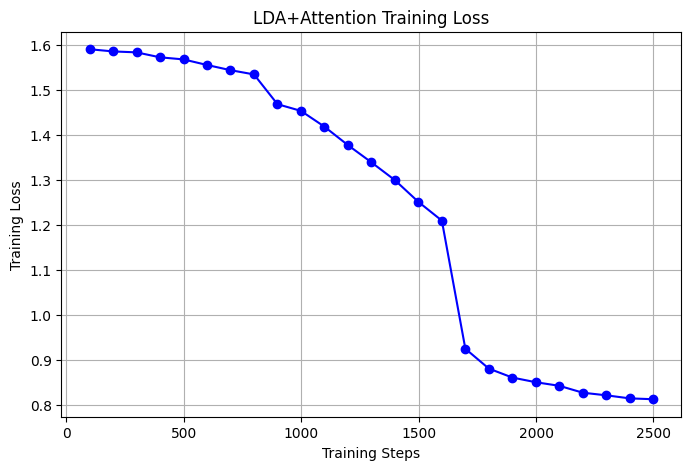

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(ts, tl, marker='o', linestyle='-', color='b')
plt.xlabel('Training Steps')
plt.ylabel('Training Loss')
plt.title('LDA+Attention Training Loss')
plt.grid(True)
plt.show()

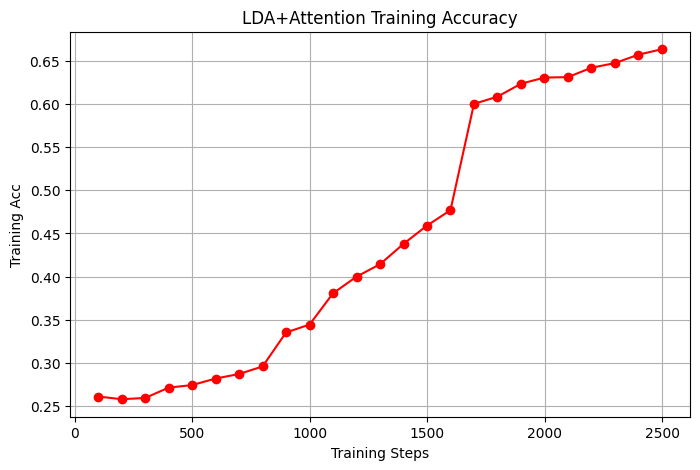

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(ts, ta, marker='o', linestyle='-', color='r')
plt.xlabel('Training Steps')
plt.ylabel('Training Acc')
plt.title('LDA+Attention Training Accuracy')
plt.grid(True)
plt.show()

In [ ]:
print("Validation metrics:")
evaluate(model, val_dataloader)

Validation metrics:


Evaluating:   0%|          | 0/180 [00:00<?, ?it/s]

Loss: 0.7514
Accuracy: 0.7060
F1 Score: 0.7067
Precision: 0.7098
Recall: 0.7060
ROC AUC: 0.9195


(0.7513688443435563,
 0.7060458651841557,
 0.7067449496665733,
 0.7098237714953075,
 0.7060458651841557,
 0.9194909951496488)

In [ ]:
print("Test metrics:")
evaluate(model, test_dataloader)

Test metrics:


Evaluating:   0%|          | 0/180 [00:00<?, ?it/s]

Loss: 0.7877
Accuracy: 0.7014
F1 Score: 0.7032
Precision: 0.7077
Recall: 0.7014
ROC AUC: 0.9127


(0.7877045303583146,
 0.7013888888888888,
 0.703151555714271,
 0.7077302768812885,
 0.7013888888888888,
 0.912704547124398)

In [ ]:
torch.save(model.state_dict(), 'LDA_model.pt')